In [1]:
import numpy as np
import pandas as pd

import time, os, sys, re, glob
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

import skimage
import skimage.io as io
from skimage.io import imread

import seaborn as sns
from scipy import stats
#from statannot import add_stat_annotation

from course_functions import random_cmap
cmap = random_cmap()

In [2]:
datapath = "./"
file_to_open = datapath + "results_infection.txt"
results_infection = pd.read_csv(file_to_open, sep = "\t", header = 0)

In [3]:
results_infection

,label,area,perimeter,mean_intensity,feret_diameter_max,major_axis_length,minor_axis_length,file,experiment,virus,replicate,image,channel
0,1,563,97.213203,7441.170515,31.622777,30.925483,23.837815,data\A1_-1_2_1_GFP_001.tif,data\A1_-1,2,1,GFP,1
1,2,809,131.420310,7060.245983,51.923020,49.090999,22.072127,data\A1_-1_2_1_GFP_001.tif,data\A1_-1,2,1,GFP,1
2,3,245,66.142136,7075.224490,25.495098,25.195313,12.987833,data\A1_-1_2_1_GFP_001.tif,data\A1_-1,2,1,GFP,1
3,4,1154,148.769553,8418.253033,52.392748,51.332793,30.641743,data\A1_-1_2_1_GFP_001.tif,data\A1_-1,2,1,GFP,1
4,5,362,96.556349,8591.488950,44.011362,42.557467,11.302005,data\A1_-1_2_1_GFP_001.tif,data\A1_-1,2,1,GFP,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13686,8792,59,29.071068,12855.118644,11.704700,11.491260,6.716684,data\P1_-1_2_1_GFP_001.tif,data\P1_-1,2,1,GFP,1
13687,8793,38,23.449747,16046.921053,10.440307,10.471301,5.149569,data\P1_-1_2_1_GFP_001.tif,data\P1_-1,2,1,GFP,1
13688,8794,56,32.485281,16166.267857,11.704700,11.470674,6.651312,data\P1_-1_2_1_GFP_001.tif,data\P1_-1,2,1,GFP,1
13689,8795,36,19.656854,15983.527778,7.615773,7.354897,6.190738,data\P1_-1_2_1_GFP_001.tif,data\P1_-1,2,1,GFP,1


## Log (Mean intensity) - new column

In [4]:
results_infection["MeanLog"] = np.log10(results_infection['mean_intensity'])
results_infection[0:5]

,label,area,perimeter,mean_intensity,feret_diameter_max,major_axis_length,minor_axis_length,file,experiment,virus,replicate,image,channel,MeanLog
0,1,563,97.213203,7441.170515,31.622777,30.925483,23.837815,data\A1_-1_2_1_GFP_001.tif,data\A1_-1,2,1,GFP,1,3.871641
1,2,809,131.420310,7060.245983,51.923020,49.090999,22.072127,data\A1_-1_2_1_GFP_001.tif,data\A1_-1,2,1,GFP,1,3.848820
2,3,245,66.142136,7075.224490,25.495098,25.195313,12.987833,data\A1_-1_2_1_GFP_001.tif,data\A1_-1,2,1,GFP,1,3.849740
3,4,1154,148.769553,8418.253033,52.392748,51.332793,30.641743,data\A1_-1_2_1_GFP_001.tif,data\A1_-1,2,1,GFP,1,3.925222
4,5,362,96.556349,8591.488950,44.011362,42.557467,11.302005,data\A1_-1_2_1_GFP_001.tif,data\A1_-1,2,1,GFP,1,3.934068


## Mock images

In [5]:
mock = results_infection.loc[results_infection["virus"]== 0]

## mean + 3x SD (Log(mean intensity))

In [6]:
std_mean = np.std(mock['MeanLog'])
mean_tot = np.mean(mock['MeanLog'])

print("Mean :"+ "\t\t" +  str(mean_tot))
print("std :"+ "\t\t" + str(std_mean))
print("Mean + 3x std :" + "\t" + str(mean_tot + (3*std_mean)))

Mean :		3.142353700369852
std :		0.07382649208707182
Mean + 3x std :	3.363833176631067


## new column = 1 if (Log(mean intensity)) > mean + 3x SD

In [7]:
results_infection['infected'] = [1 if x >= (mean_tot+(3*std_mean)) else 0 for x in results_infection['MeanLog']]

results_infection[0:5]

,label,area,perimeter,mean_intensity,feret_diameter_max,major_axis_length,minor_axis_length,file,experiment,virus,replicate,image,channel,MeanLog,infected
0,1,808,141.562446,1155.670792,53.712196,49.603974,23.217868,20210216_000_A_34_GFP.tif,20210216,0,A,34,GFP,3.062834,0
1,2,5826,329.202056,1010.459149,114.947814,113.896803,66.078677,20210216_000_A_34_GFP.tif,20210216,0,A,34,GFP,3.004519,0
2,3,1775,179.012193,1040.324507,60.440053,54.822006,44.702211,20210216_000_A_34_GFP.tif,20210216,0,A,34,GFP,3.017169,0
3,4,108,44.520815,1003.472222,15.264338,13.876527,10.855278,20210216_000_A_34_GFP.tif,20210216,0,A,34,GFP,3.001505,0
4,5,4798,281.296465,1135.365777,91.809586,86.678352,72.155273,20210216_000_A_34_GFP.tif,20210216,0,A,34,GFP,3.055136,0


## new table for counting absolute number of cells
### groupby.sum( )

In [8]:
results_count = results_infection.drop(["label", "area", "perimeter", "mean_intensity", "major_axis_length", "minor_axis_length", "image", "feret_diameter_max", "MeanLog"], axis=1)
results_count["total_cells"]= 1.0
results_counted = results_count.groupby(["experiment", "virus", "replicate", "channel"]).sum().reset_index()
results_counted["%_positive"] = results_counted["infected"]/results_counted["total_cells"]*100
results_counted

,experiment,virus,replicate,channel,infected,total_cells,%_positive
0,20210216,0,A,GFP,0,8162.0,0.000000
1,20210216,0,B,GFP,4,7070.0,0.056577
2,20210216,0,C,GFP,8,6169.0,0.129681
3,20210216,49,A,GFP,3713,6524.0,56.912937
4,20210216,49,B,GFP,3476,5977.0,58.156266
5,20210216,49,C,GFP,4396,7252.0,60.617761
6,20210216,49,D,GFP,3471,6073.0,57.154619
7,20210216,131,A,GFP,3267,5758.0,56.738451
8,20210216,131,B,GFP,4232,6375.0,66.384314
9,20210216,131,C,GFP,1946,5005.0,38.881119


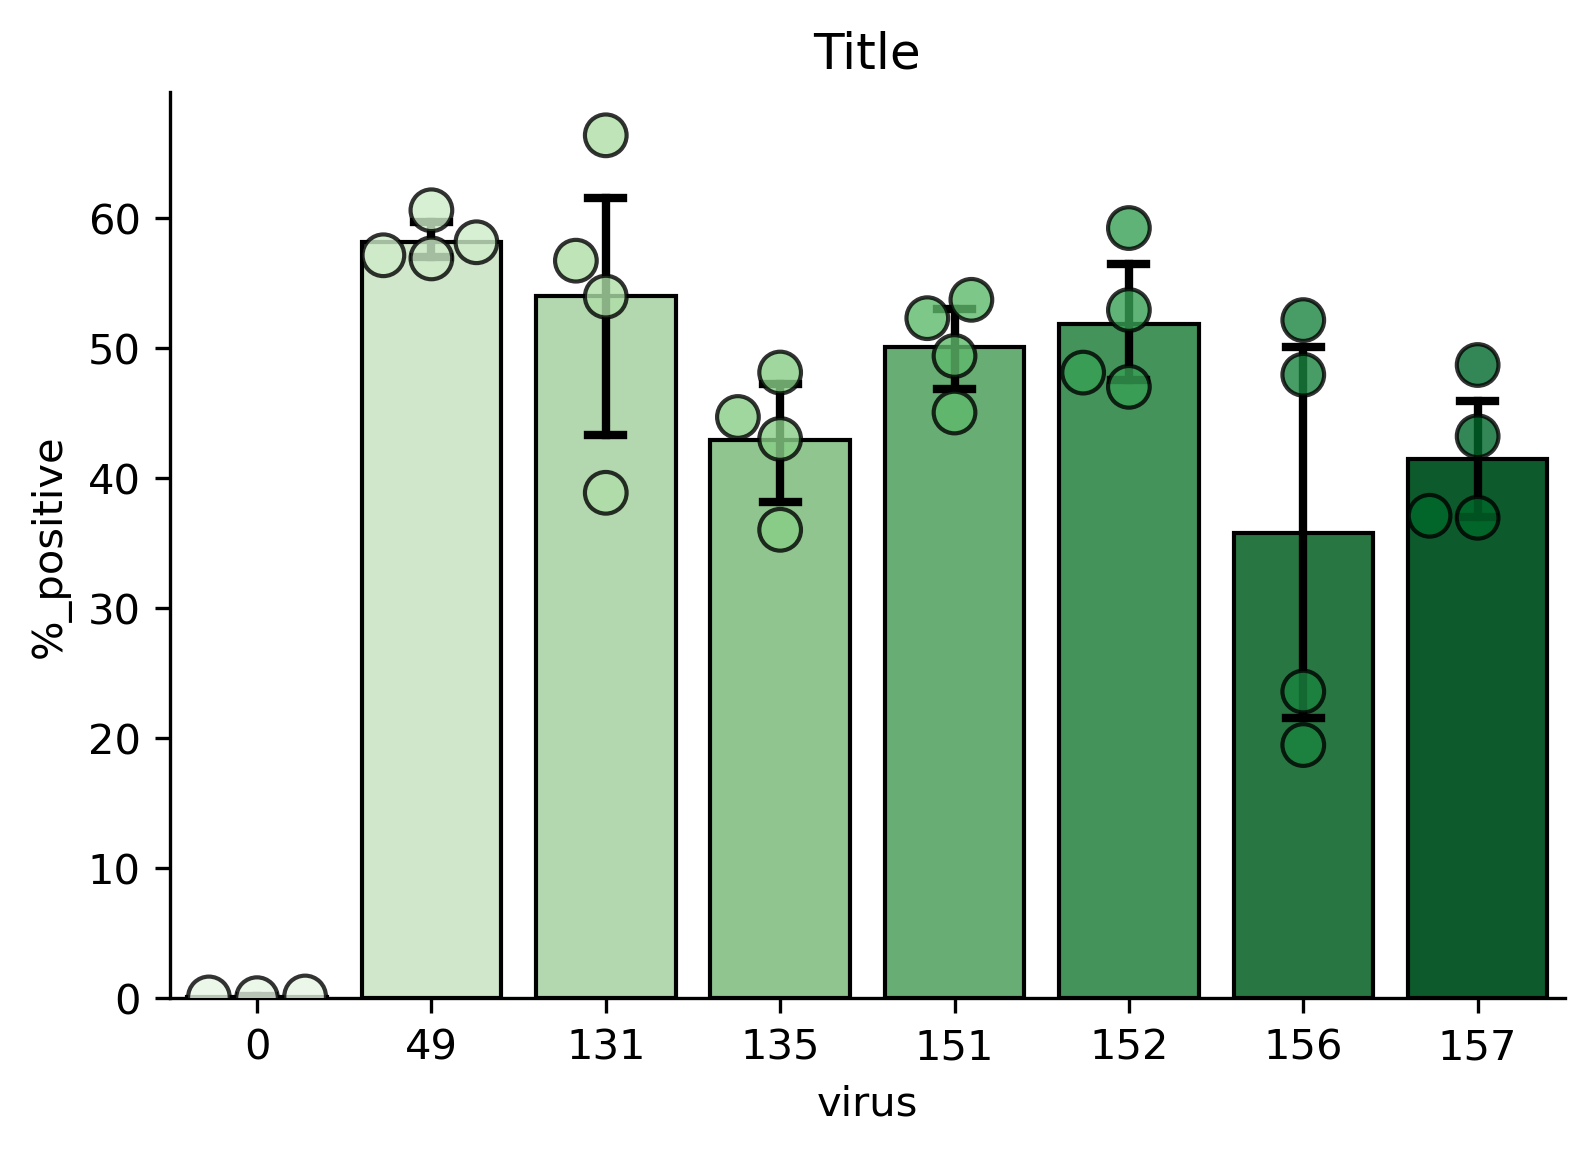

In [13]:
title = "Title"
xlabel = "xlabel"
ylabel = "ylabel"


data = results_counted
x = "virus"
y = "%_positive"
hue = "replicate"
palette = "Greens"

fig, ax = plt.subplots()
g = sns.barplot(data = data,
                x = x,
                y = y, 
                #hue = hue,
                palette = palette,
                linewidth=1,
                edgecolor = "black",
                capsize=.2,
                errcolor = "black",
                errwidth=2,
                 )

g1 = sns.swarmplot(data = data,
                x = x,
                y = y, 
                #hue = hue,
                palette = palette,
                size = 10,
                linewidth=1,
                edgecolor = "black",
                alpha = 0.8,
                )




plt.title(title)

#plt.xlabel(xlabel,size="large")
#ax.set_xticklabels(["SARS-CoV", "SARS-CoV-2", "mock"])

#plt.ylabel(ylabel,size="large")
#plt.ylim([0,100])
#plt.yscale("linear")

#plt.legend(loc="upper left", bbox_to_anchor=(1,1), frameon=False)

sns.despine()

#plt.savefig("total_cells_filtered.pdf", bbox_inches = 'tight')

In [9]:
results_infection_summary = results_infection.groupby(["experiment", "virus", "replicate", "channel"]).mean().reset_index()
results_infection_summary['infected_%'] = results_infection_summary['infected']*100
results_infection_summary

,experiment,virus,replicate,channel,label,area,perimeter,mean_intensity,feret_diameter_max,major_axis_length,minor_axis_length,image,MeanLog,infected,infected_%
0,20210216,0,A,GFP,1044.874786,1892.275178,185.375377,1353.427692,67.628281,65.068811,33.987954,35.633791,3.125965,0.000000,0.000000
1,20210216,0,B,GFP,896.341443,2136.352475,192.923049,1460.963759,70.021702,67.188641,35.263996,39.387412,3.160296,0.000566,0.056577
2,20210216,0,C,GFP,828.319177,2545.419355,217.626941,1418.079453,77.616740,74.848512,39.460034,43.342843,3.143474,0.001297,0.129681
3,20210216,49,A,GFP,830.200950,2231.765328,208.731200,4187.860341,74.290321,70.164355,37.473655,2.505671,3.492711,0.569129,56.912937
4,20210216,49,B,GFP,760.072779,2465.523339,216.139679,4248.620679,77.130325,73.103275,38.149591,2.414924,3.504937,0.581563,58.156266
5,20210216,49,C,GFP,919.787231,2107.837286,201.699549,4427.391700,72.639605,68.964246,36.142449,6.450496,3.524598,0.606178,60.617761
6,20210216,49,D,GFP,793.479829,2510.917668,221.096490,3992.985191,78.803908,74.686757,39.071675,10.282727,3.486312,0.571546,57.154619
7,20210216,131,A,GFP,733.691212,2513.502084,221.616680,4266.429146,77.726711,73.500893,39.628972,18.486975,3.492617,0.567385,56.738451
8,20210216,131,B,GFP,808.515451,2246.336157,204.917911,4956.614347,72.789852,68.978974,36.639429,22.397804,3.567629,0.663843,66.384314
9,20210216,131,C,GFP,635.326673,3119.190410,247.971166,3050.957292,87.239436,83.337096,43.414023,26.625774,3.380527,0.388811,38.881119


No handles with labels found to put in legend.


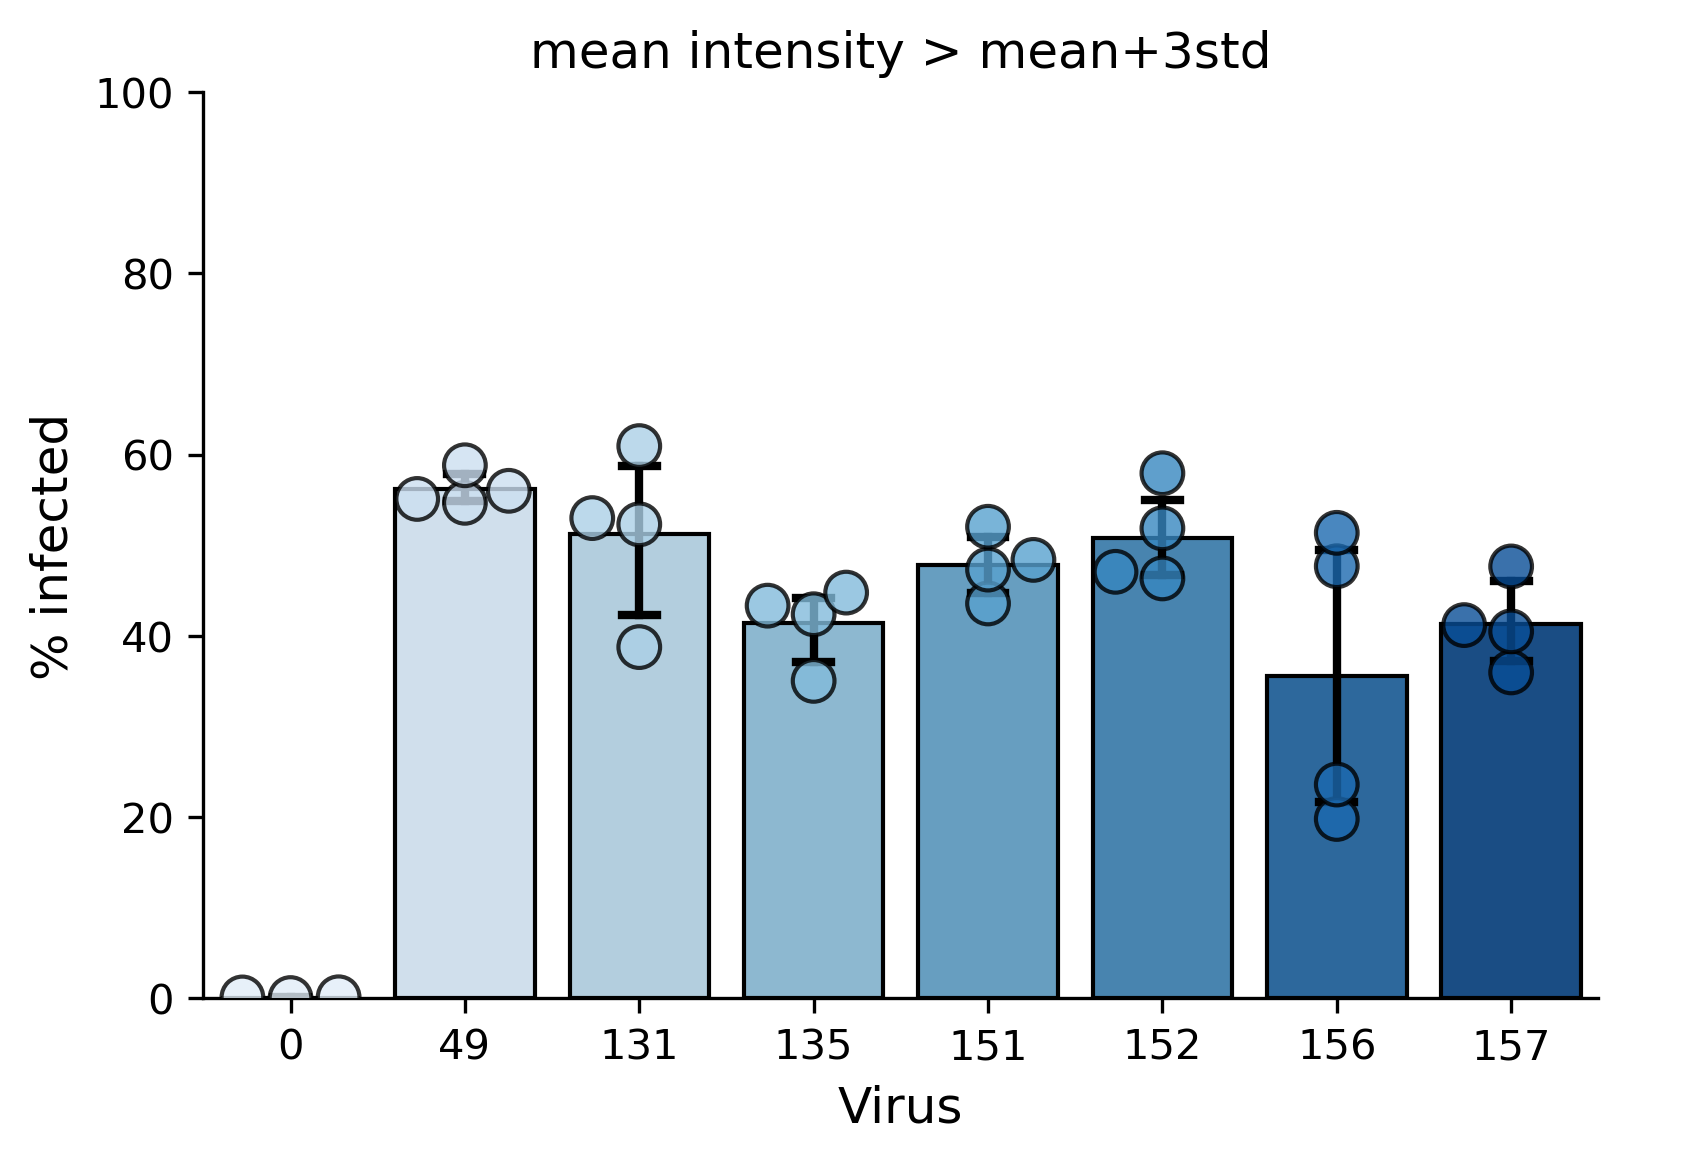

In [23]:
fig, ax = plt.subplots()
g = sns.barplot(data= all_results_summary,
                x='virus',
                y='infected_mean_3std_%', 
                #hue="replicate",
                palette = "Blues",
                linewidth=1,
                edgecolor = "black",
                capsize=.2,
                errcolor = "black",
                errwidth=2,
                 )

g1 = sns.swarmplot(data= all_results_summary,
                x='virus',
                y='infected_mean_3std_%',
                #hue="replicate",
                dodge = True, 
                palette = "Blues",
                size = 10,
                linewidth=1,
                edgecolor = "black",
                alpha = 0.8,
                )

plt.yscale("linear")
plt.ylim([0,100])
#ax.set_xticklabels(["SARS-CoV", "SARS-CoV-2", "mock"])
plt.title("mean intensity > mean+3std")
plt.ylabel("% infected",size="large")
plt.xlabel("Virus",size="large")
plt.legend(loc="upper left", bbox_to_anchor=(1,1), frameon=False)

sns.despine()

plt.savefig("mean_3std_filtered.pdf", bbox_inches = 'tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

49_GFP v.s. 131_GFP: t-test paired samples, P_val=4.873e-01 stat=7.898e-01
49_GFP v.s. 135_GFP: t-test paired samples, P_val=1.905e-02 stat=4.623e+00
49_GFP v.s. 151_GFP: t-test paired samples, P_val=2.013e-02 stat=4.530e+00
49_GFP v.s. 152_GFP: t-test paired samples, P_val=1.278e-01 stat=2.090e+00
49_GFP v.s. 156_GFP: t-test paired samples, P_val=5.507e-02 stat=3.058e+00


No handles with labels found to put in legend.


49_GFP v.s. 157_GFP: t-test paired samples, P_val=1.657e-02 stat=4.867e+00


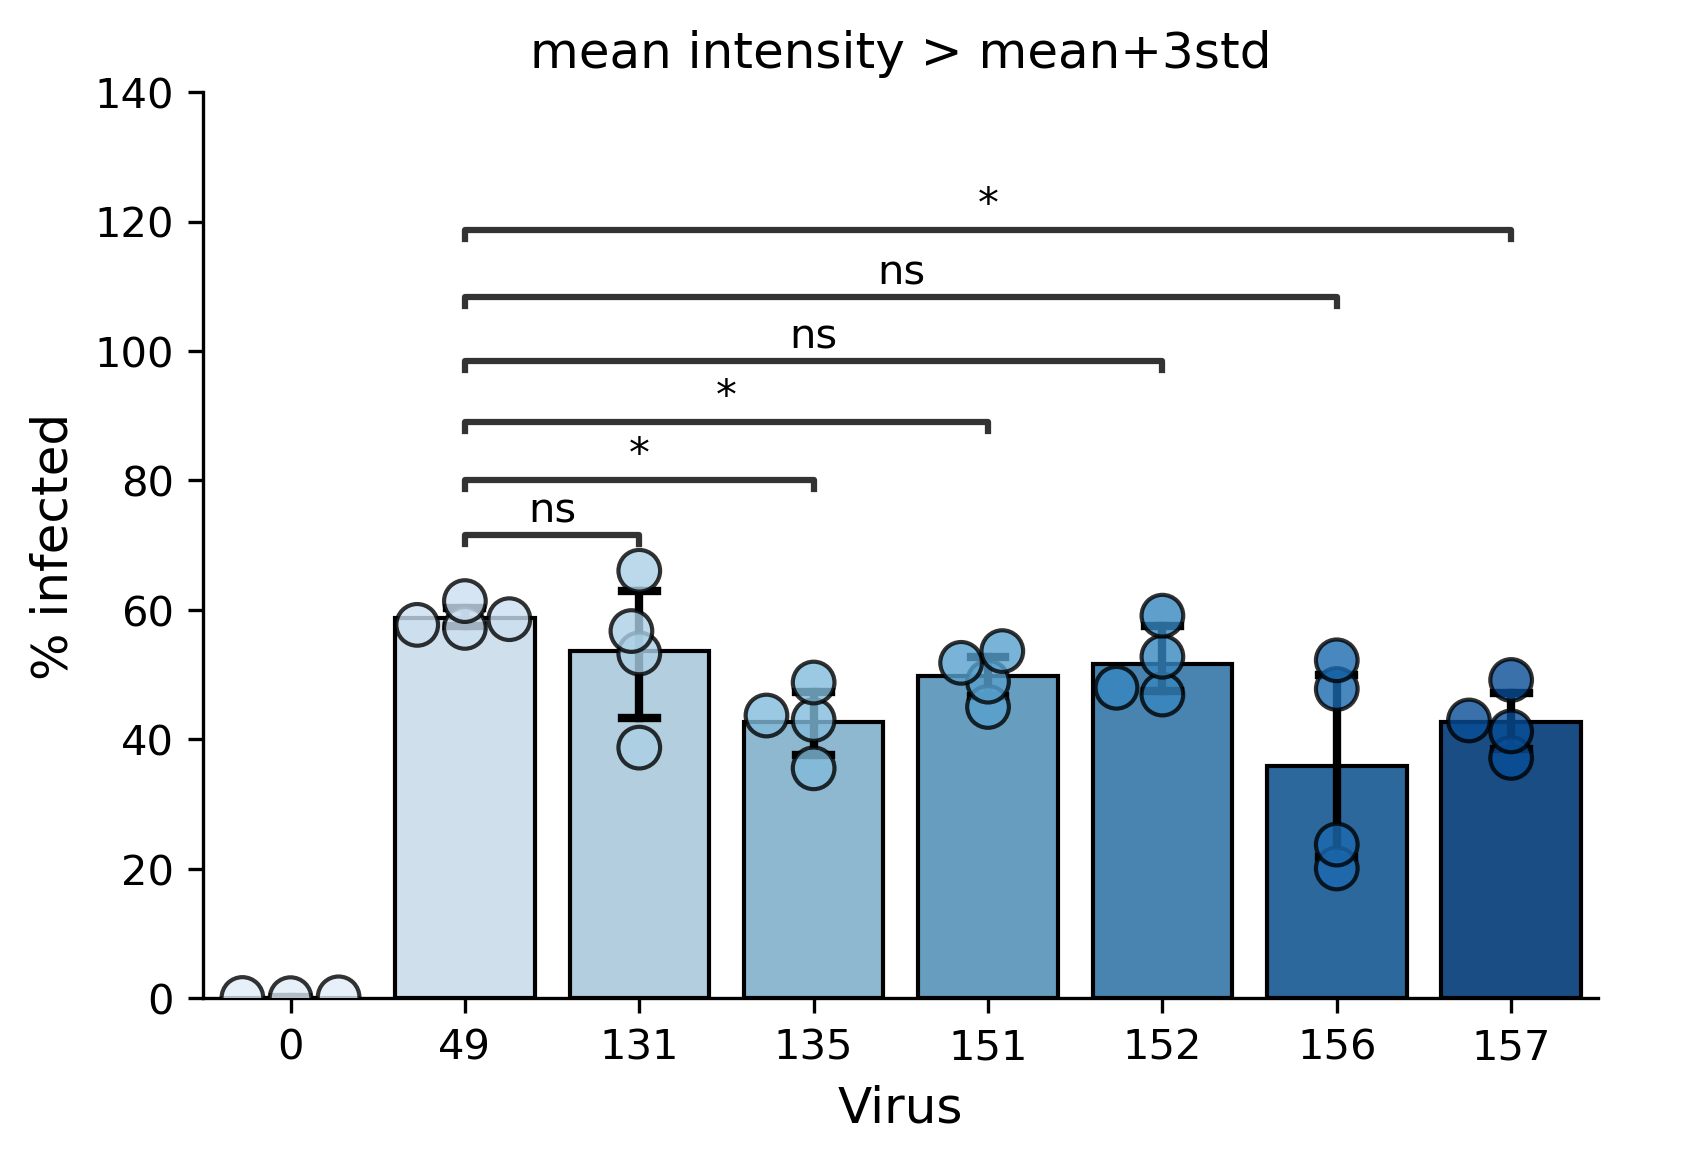

In [41]:
fig, ax = plt.subplots()
g = sns.barplot(data= all_results_summary,
                x='virus',
                y='infected_mean_3std_%', 
                #hue="replicate",
                palette = "Blues",
                linewidth=1,
                edgecolor = "black",
                capsize=.2,
                errcolor = "black",
                errwidth=2,
                 )

g1 = sns.swarmplot(data= all_results_summary,
                x='virus',
                y='infected_mean_3std_%',
                #hue="replicate",
                dodge = True, 
                palette = "Blues",
                size = 10,
                linewidth=1,
                edgecolor = "black",
                alpha = 0.8,
                )

x = "virus"
y='infected_mean_3std_%'
hue = "channel"

box_pairs=[
    ((49, "GFP"), (131, "GFP")),
    ((49, "GFP"), (135, "GFP")),
    ((49, "GFP"), (151, "GFP")),
    ((49, "GFP"), (152, "GFP")),
    ((49, "GFP"), (156, "GFP")),
    ((49, "GFP"), (157, "GFP")),
    ]

add_stat_annotation(ax, data=all_results_summary, x=x, y=y, hue=hue, box_pairs=box_pairs, test='t-test_paired',  comparisons_correction= None, loc='inside', verbose=2)

plt.yscale("linear")
plt.ylim([0,140])
#ax.set_xticklabels(["SARS-CoV", "SARS-CoV-2", "mock"])
plt.title("mean intensity > mean+3std")
plt.ylabel("% infected",size="large")
plt.xlabel("Virus",size="large")
plt.legend(loc="upper left", bbox_to_anchor=(1,1), frameon=False)

sns.despine()

plt.savefig("mean_3std_stats.pdf", bbox_inches = 'tight')

In [ ]:
x = "virus"
y='infected_mean_3std_%'
hue = "temperature"

box_pairs=[
    (("Fr", "33"), ("Fr", "37")),
    (("Wu", "33"), ("Wu", "37")),
    (("Mock", "33"), ("Mock", "37")),
    (("Fr", "33"), ("Wu", "33")),
    (("Fr", "37"), ("Wu", "37")),
    ]

add_stat_annotation(ax, data=finalraw3, order=["Fr", "Wu", "Mock"], x=x, y=y, hue=hue, box_pairs=box_pairs, test='t-test_paired',  comparisons_correction= None, loc='inside', verbose=2)
